In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
import numpy as np
from scipy.ndimage import label, find_objects
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import cv2
import os
import torch

### Utilities

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]

    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

### Check if the Image Has Low Contrast

In [3]:
def measure_contrast(image, threshold=245, overexposure_ratio=0.3):
    """
    Detects if an image is overexposed.

    Parameters:
    - image: Input image (numpy array).
    - threshold: Pixel value threshold to consider a pixel overexposed.
    - overexposure_ratio: Proportion of pixels above the threshold to classify the image as overexposed.

    Returns:
    - Boolean indicating if the image is overexposed.
    """
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Calculate the histogram of pixel values
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    hist = hist / hist.sum()

    # Calculate the proportion of pixels above the threshold
    overexposed_pixels = hist[threshold:].sum()

    return overexposed_pixels > overexposure_ratio, overexposed_pixels

# check all the images in the folder and print the path of overexposed ones
def check_overexposed(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith(".jpg"):
            image_path = os.path.join(folder_path, file)
            try:
                image = Image.open(image_path).convert("RGB")
            except:
                print("File problem", image_path)
                continue
            image = np.array(image)
            has_low_contrast, overexposed_pixels = measure_contrast(image)
            if has_low_contrast:
                print("Overexposed image", overexposed_pixels, image_path)


# folder_path = "C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24"
# check_overexposed(folder_path)

### 1) Open and Validate a Random File

In [4]:
folder_path = "C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24/"

#get a random image from a folder path
def get_random_image(folder_path):
    files = os.listdir(folder_path)
    image_path = folder_path + files[np.random.randint(len(files))]
    return image_path

test_image_path = get_random_image(folder_path)
test_image_path = 'C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24/16034-0.jpg'


#validate the image exists and is a valid image file
try:
    image = Image.open(test_image_path).convert("RGB")
except FileNotFoundError:
    print("File not found")
except IOError:
    print("Not a valid image file")
else:
    print("File found and valid image file")

#transform to an ndarray
test_image = np.array(image)
test_image_path


File found and valid image file


'C:/Users/jflir/Documents/Arbocensus/ArbocensusData/20230829_24/16034-0.jpg'

### 2) Start with the guess that the tree is at the center

(800, 600)
[300, 400]


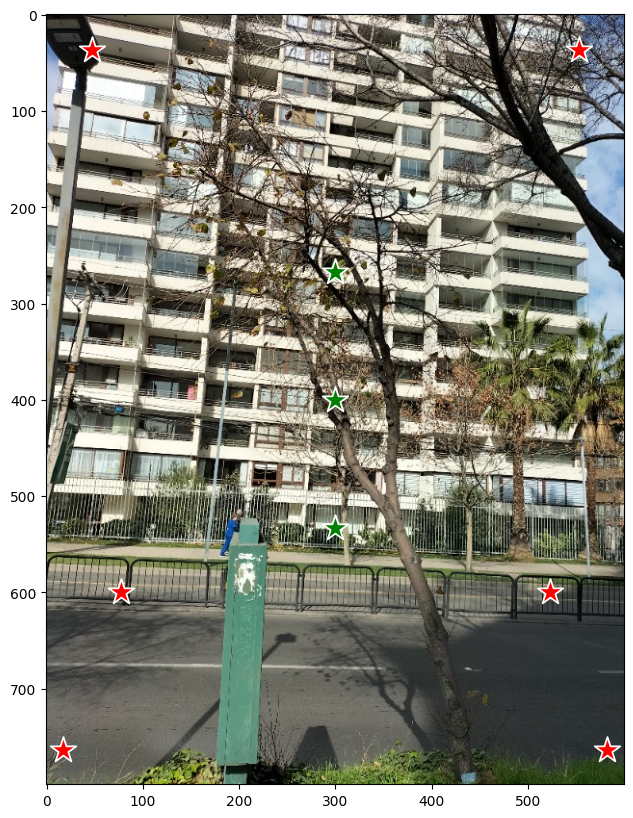

In [5]:
size = test_image.shape[:2]
center = [size[1]//2, size[0]//2]

print(size)
print(center)

x_deviation = (size[1]//2) / 1.10
y_deviation = (size[0]//2) / 1.10
left_bottom_corner1 = [center[0] - x_deviation + 50, center[1] + (size[0]//2)/2]
right_bottom_corner1 = [center[0] + x_deviation - 50, center[1] + (size[0]//2)/2]
left_bottom_corner2 = [center[0] - x_deviation - 10, center[1] + (size[0]//2)/1.1]
right_bottom_corner2 = [center[0] + x_deviation + 10, center[1] + (size[0]//2)/1.1]
top_left_corner = [center[0] - x_deviation + 20, center[1] - y_deviation]
top_right_corner = [center[0] + x_deviation - 20, center[1] - y_deviation]
bottom_center = [center[0], center[1] + size[0]//6]
top_center = [center[0], center[1] - size[0]//6]

reference_points = [center, bottom_center, top_center, left_bottom_corner1, right_bottom_corner1, left_bottom_corner2, right_bottom_corner2, top_left_corner, top_right_corner]
input_points = np.array(reference_points)
input_label = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0])

plt.figure(figsize=(10,10))
plt.imshow(test_image)
show_points(input_points, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [6]:
input_box = np.array([0, 0, size[1], size[0]])
input_box

array([  0,   0, 600, 800])

In [7]:
sam_checkpoint = "../weights_and_checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(test_image)


masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=False,
    box=input_box,
)

In [8]:
from scipy.ndimage import label

def isolate_largest_segment(mask):
    """
    Isolates the largest closed segment in a boolean mask.

    Parameters:
    - mask: Input boolean mask (numpy array).

    Returns:
    - A boolean mask with only the largest closed segment.
    """
    labeled_mask, num_features = label(mask)
    
    if num_features == 0:
        return np.zeros_like(mask, dtype=bool)
    
    segment_sizes = np.bincount(labeled_mask.flat)
    segment_sizes[0] = 0
    
    largest_segment_label = segment_sizes.argmax()
    
    largest_segment_mask = labeled_mask == largest_segment_label
    
    return largest_segment_mask
objective_mask = masks[0]
score = scores[0]
print(test_image.shape)

isolated_mask = isolate_largest_segment(objective_mask)
isolated_bbox = find_objects(isolated_mask)[0]
y_slice, x_slice = isolated_bbox

print(isolated_mask.shape, objective_mask.shape)
# Convert slices to bbox coordinates
isolated_bbox = np.array([x_slice.start, y_slice.start, x_slice.stop, y_slice.stop])

(800, 600, 3)
(800, 600) (800, 600)


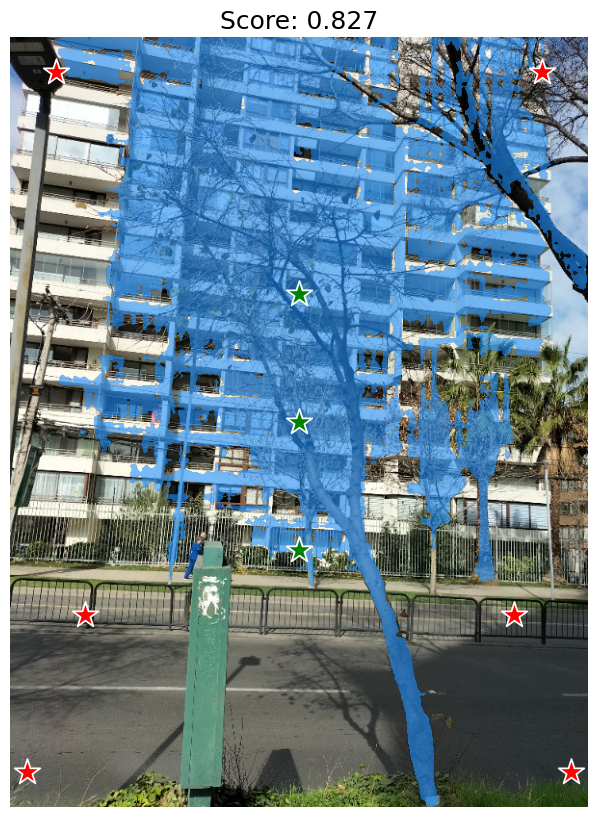

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(test_image)
show_mask(isolated_mask, plt.gca())
show_points(input_points, input_label, plt.gca())
plt.title(f"Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show()


  

(600,)


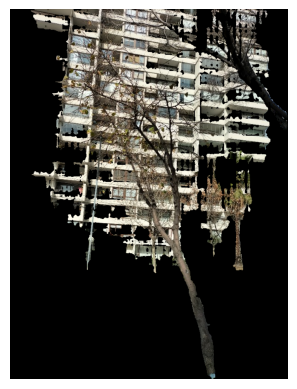

In [10]:
#given a mask change the false values to 255 in the image
def mask_to_image(mask, image, mask_value=0):
    for i in range(len(mask)):
        for j in range(len(mask[i])):
            if mask[i][j] == False:
                image[i][j] = mask_value
    return image

isolated_test_image = test_image.copy()
isolated_test_image = mask_to_image(isolated_mask, isolated_test_image)

print(isolated_mask[0].shape)

#display the image
plt.imshow(isolated_test_image)
plt.axis('off')
plt.show()


### 2) Second Segmentation: Filter the objects of different depths

In [11]:
from transformers import pipeline

pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")
depth_pil = pipe(image)["depth"]

# Sample grayscale image
depth_image_array = np.array(depth_pil)

isolated_depth_image_array = mask_to_image(isolated_mask, depth_image_array, mask_value=0)

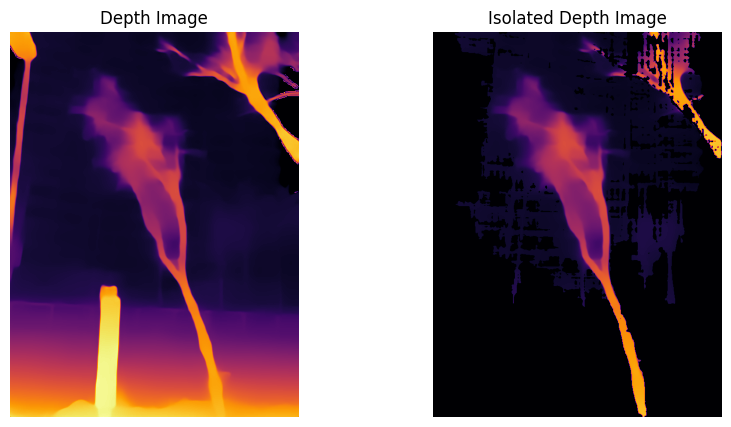

In [12]:
#display the depth_pil and the isolated_depth_image_array in a subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(depth_pil, cmap="inferno")
ax[0].axis('off')
ax[0].set_title("Depth Image")
ax[1].imshow(isolated_depth_image_array, cmap="inferno")
ax[1].axis('off')
ax[1].set_title("Isolated Depth Image")
plt.show()

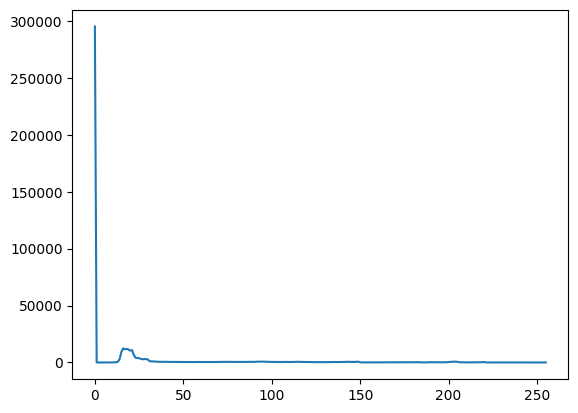

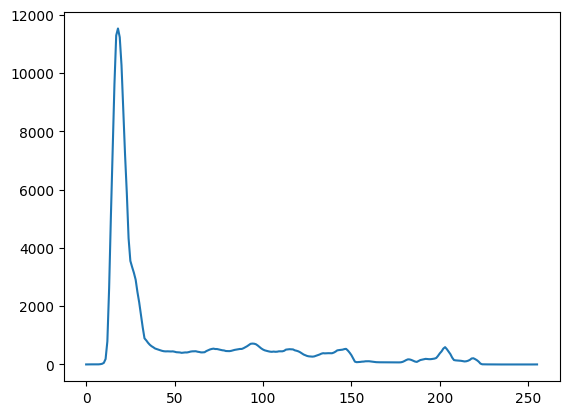

51 1166.5759183900225
[18]
0 [0]
[18] [18]


In [13]:
from scipy.signal import find_peaks

def detect_outliers(data, threshold=3):
    """
    Detects outliers in an array of data.

    Parameters:
    - data: Input data array.
    - threshold: Threshold for the z-score to consider a value an outlier.

    Returns:
    - List of indices of the outliers.
    """
    mean = np.mean(data)
    std = np.std(data)
    z_scores = np.abs((data - mean) / std)
    outliers = np.where(z_scores > threshold)[0]
    return outliers

def moving_average(data, window_size=3):
    """
    Calculates the moving average of an array of data. 

    Parameters:
    - data: Input data array.
    - window_size: Size of the window for the moving average.

    Returns:
    - Array of the same size with the moving average of the input data.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1")
    
    # Convert data to float to handle NaNs
    data = np.array(data, dtype=float)
    
    # Pad the data with the edges mean at the beginning to maintain the same size array
    pad = window_size // 2
    padded_data = np.pad(data, (pad, pad), mode='edge')

    # Calculate the moving average using a sliding window
    cumsum = np.cumsum(np.insert(padded_data, 0, 0)) 
    moving_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size

    filtered_data = moving_avg[:len(data)]  # Ensure the result has the same size as input data
    filtered_data = np.nan_to_num(filtered_data, nan=0)
    return filtered_data


def isolate_close_values(values):
    slopes = np.diff(values) if len(values) > 1 else [0]
    slopes_mean = int(np.mean(slopes))
    slopes_threshold = slopes_mean

    groups = []
    current_group = [values[0]]
    print(slopes_threshold, slopes)
    if len(slopes) >= 2:
        for i in range(1, len(values)):
            if slopes[i-1] <= slopes_threshold:
                current_group.append(values[i])
            else:
                groups.append(current_group)
                current_group = [values[i]]
        
        groups.append(current_group)
        groups = [int(np.mean(group)) for group in groups]
    else:
        groups = values

    return groups


def get_depth_statistics(depth_image_array):
    # get a count list of the unique values in the image
    hist, bin_edges = np.histogram(depth_image_array, bins=256, range=(0, 255))
    #with the index as the x axis and the count as the y axis
    plt.plot(hist)
    plt.show()

    outliers = detect_outliers(hist)

    #replace the outliers with 0
    for outlier in outliers:
        hist[outlier] = 0


    hist = moving_average(hist, 5)

    plt.plot(hist)
    plt.show()

    # get the count statistics of the image
    mean = int(np.sum([hist[i]*i for i in range(len(hist))])/np.sum(hist))
    std = int(np.sqrt(np.sum([hist[i]*(i-mean)**2 for i in range(len(hist))])/np.sum(hist)))
    threshold = np.mean(hist) + np.std(hist)/4

    print(std, threshold)

    # Find peaks with the dynamic threshold
    peaks, _ = find_peaks(hist, height=threshold)
    print(peaks)

    #isolate near peaks
    filtered_peaks = isolate_close_values(peaks)

    print(peaks, filtered_peaks)

    #transform hist to a 2D array (index, count)
    hist = hist.reshape(-1, 1)
    #add the index as a feature
    hist = np.hstack([np.arange(len(hist)).reshape(-1, 1), hist])
    #cast the hist to a int32
    hist = hist.astype(np.int32)

    return filtered_peaks, hist

filtered_peaks, hist = get_depth_statistics(isolated_depth_image_array)


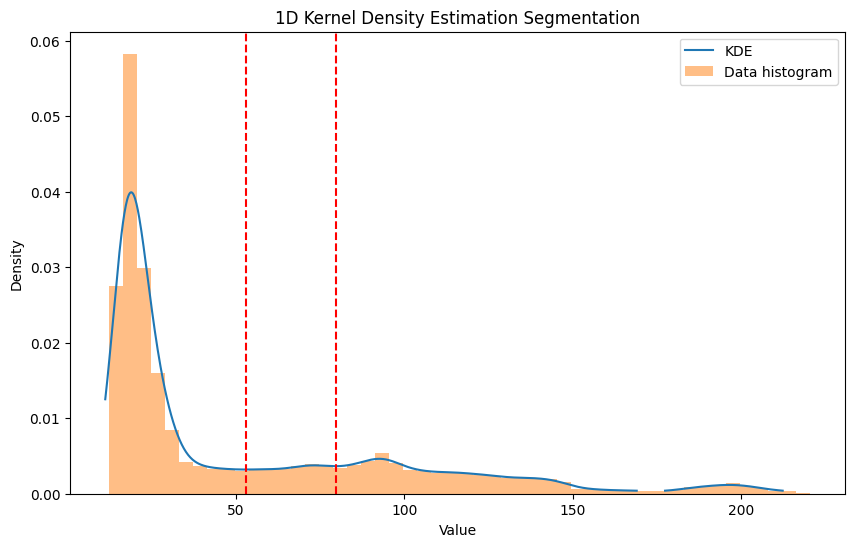

In [14]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def kde_segmentation(data, bandwidth=None, plot=True, threshold=0.01):
    """
    Perform 1D Kernel Density Estimation (KDE) segmentation.

    Parameters:
    data (array-like): The data to be segmented.
    bandwidth (float, optional): The bandwidth for KDE. If None, it will be automatically determined.
    plot (bool, optional): If True, plots the KDE and segmentation.
    threshold (float, optional): The percentage threshold to filter low-density values.

    Returns:
    segments (list): A list of arrays, each containing a segment of the data.
    minima (array): The values of the local minima used for segmentation.
    """
    # Perform KDE
    kde = gaussian_kde(data, bw_method=bandwidth)

    # Evaluate KDE on a grid
    x_grid = np.linspace(data.min() - 1, data.max() + 1, 1000)
    kde_values = kde(x_grid)

    # Apply threshold to filter low-density values
    threshold_value = threshold * np.max(kde_values)
    kde_values[kde_values < threshold_value] = np.nan

    # Find local minima to identify segments
    peaks, _ = find_peaks(-kde_values)
    minima = x_grid[peaks]

    # Function to segment data based on thresholds
    def segment_data(data, minima):
        segments = []
        last_min = data.min() - 1
        for min_val in minima:
            segments.append(data[(data > last_min) & (data <= min_val)])
            last_min = min_val
        segments.append(data[data > last_min])
        return segments

    # Segment the data
    segments = segment_data(data, minima)

    # Plot KDE and the segmentation
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x_grid, kde_values, label='KDE')
        for min_val in minima:
            plt.axvline(min_val, color='r', linestyle='--')
        plt.hist(data, bins=50, density=True, alpha=0.5, label='Data histogram')
        plt.legend()
        plt.title('1D Kernel Density Estimation Segmentation')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.show()

    return segments, minima

# Example usage
data = isolated_depth_image_array.reshape(-1, 1)
data = data[data != 0]
data = moving_average(data, 25)
segments, minima = kde_segmentation(data)

In [15]:
len(segments), segments

(3,
 [array([22.44, 22.44, 22.44, ..., 41.88, 42.92, 49.12]),
  array([55.28, 62.28, 69.28, ..., 66.44, 72.64, 78.84]),
  array([ 83.76,  91.2 ,  98.72, ..., 220.24, 220.36, 220.44])])

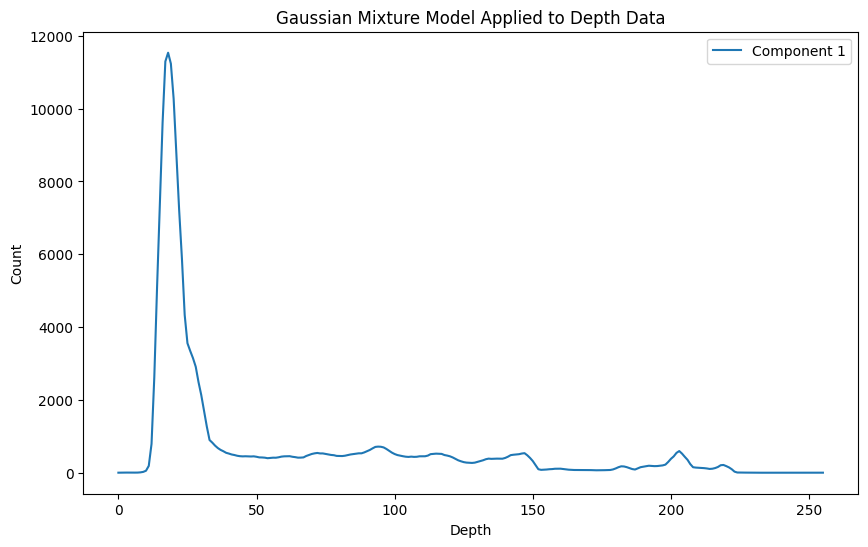

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def plot_gmm(depths, counts, n_components=2):
    """
    Fits a Gaussian Mixture Model to a histogram and plots the results.

    Parameters:
    - hist: Input histogram data.
    - n_components: Number of components for the Gaussian Mixture Model.
    """
    # Plot the results
    plt.figure(figsize=(10, 6))
    for i in range(n_components):
        component_data = depths[labels == i]
        component_counts = counts[labels == i]
        plt.plot(component_data, component_counts, label=f'Component {i+1}')

    plt.title('Gaussian Mixture Model Applied to Depth Data')
    plt.xlabel('Depth')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

def fit_gmm(hist, n_components=2):
    """
    Fits a Gaussian Mixture Model to a histogram.

    Parameters:
    - hist: Input histogram data.
    - n_components: Number of components for the Gaussian Mixture Model.

    Returns:
    - Tuple with the depth data, counts, and component labels.
    """
    # Separar los datos de profundidad y las cuentas
    depths = hist[:, 0].reshape(-1, 1)
    counts = hist[:, 1]

    # Aplicar el modelo GMM
    gmm = GaussianMixture(n_components=n_components, random_state=0, covariance_type='full')
    gmm.fit(depths, counts)
    labels = gmm.predict(depths)

    return depths, counts, labels

def separate_components(depths, labels):
    """
    Separates the components of a Gaussian Mixture Model.

    Parameters:
    - depths: Depth data.
    - labels: Component labels.

    Returns:
    - List of depth data for each component.
    """
    components = []
    for i in np.unique(labels):
        component_data = depths[labels == i]
        components.append(component_data)

    return components


n_components = len(filtered_peaks)
depths, counts, labels = fit_gmm(hist, n_components=n_components)
plot_gmm(depths, counts, n_components=n_components)

components = separate_components(depths, labels)

In [17]:
len(components)

1

In [18]:
def get_filtered_depth_segments(components, depth_image_array):
    filtered_depth_images = []
    for i in range(len(components)):
        start_roi = np.min(components[i])
        end_roi = np.max(components[i])
        filtered_depth_image = depth_image_array.copy()
        filtered_depth_image[depth_image_array >= end_roi] = 0
        filtered_depth_image[depth_image_array < start_roi] = 0
        filtered_depth_images.append(filtered_depth_image)
    return filtered_depth_images

filtered_depth_images = get_filtered_depth_segments(segments, depth_image_array)

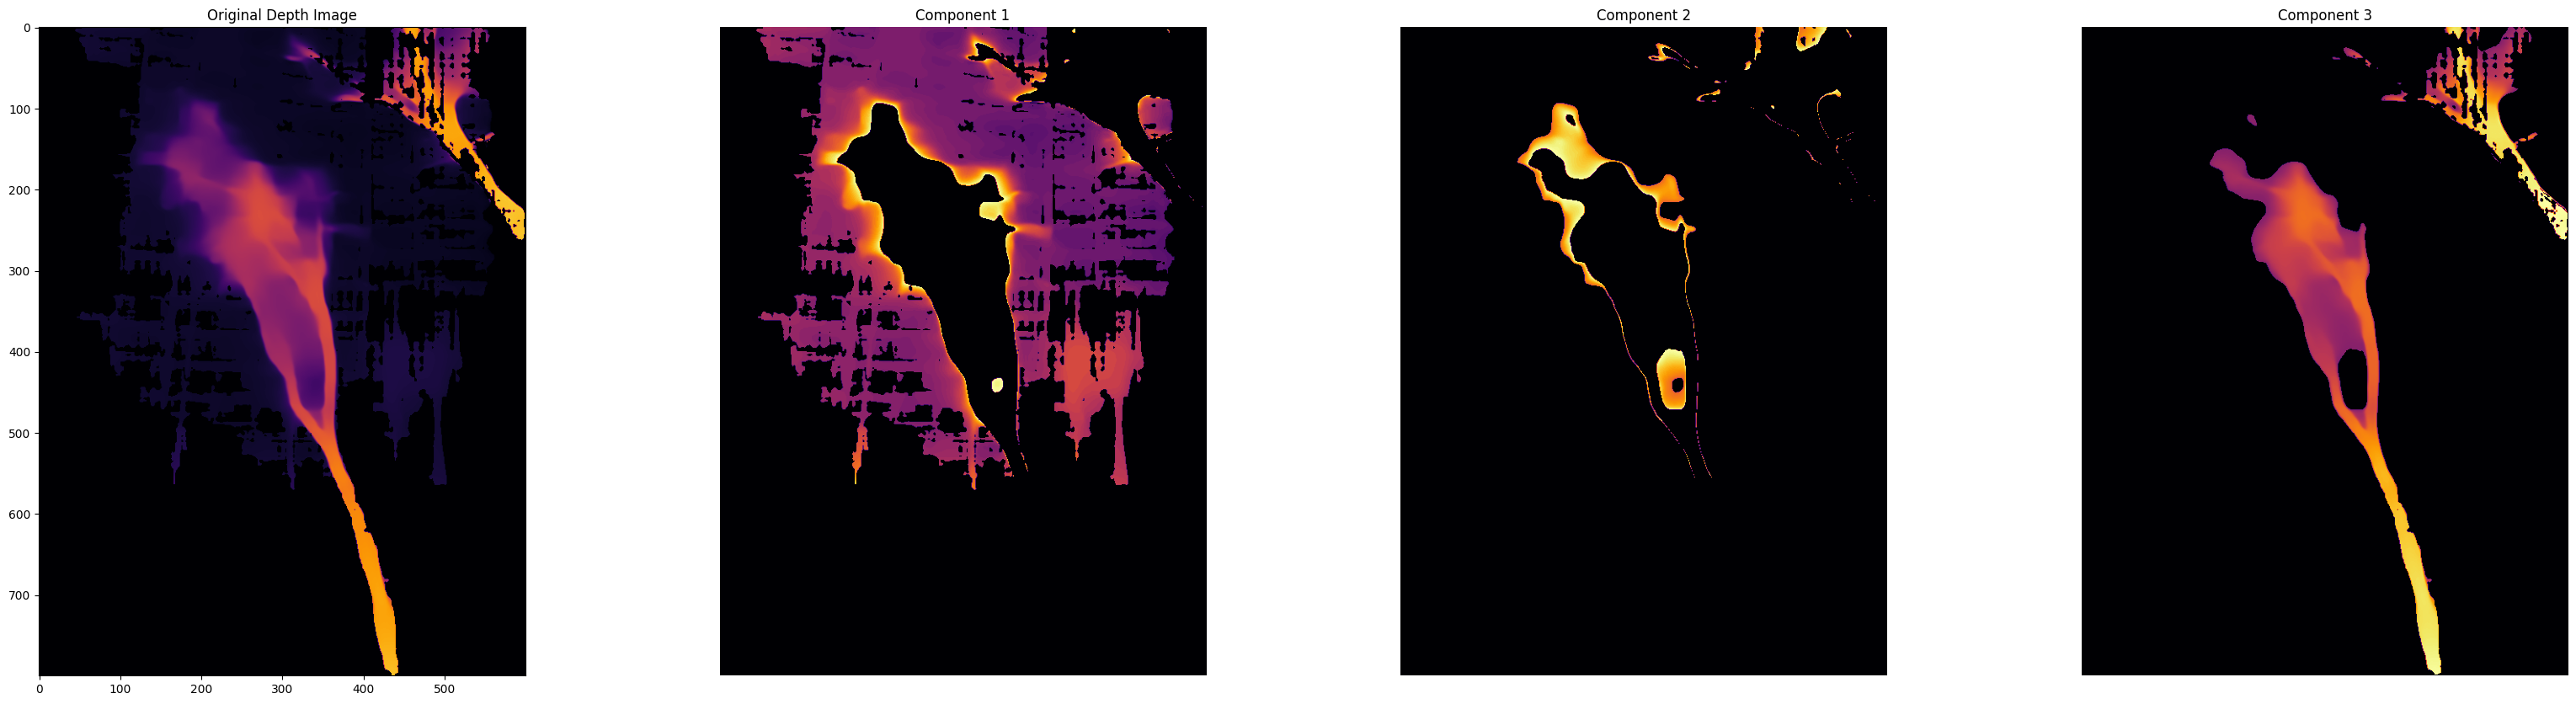

In [19]:
def plot_filtered_depth_images(filtered_depth_images, depth_image_array):
    """
    Plots the filtered depth images.

    Parameters:
    - filtered_depth_images: List of filtered depth images.
    """
    n_images = len(filtered_depth_images) + 1
    fig, axs = plt.subplots(1, n_images, figsize=(10 * n_images, 10))
    axs[0].imshow(depth_image_array, cmap='inferno')
    axs[0].set_title('Original Depth Image')
    for i, filtered_depth_image in enumerate(filtered_depth_images):
        axs[i+1].imshow(filtered_depth_image, cmap='inferno')
        axs[i+1].set_title(f'Component {i+1}')
        axs[i+1].axis('off')
    plt.show()

#display the depth image array and the filtered depth image array
plot_filtered_depth_images(filtered_depth_images, depth_image_array)

#### Get the best segment based on their depth, position to the global center and size of the biggest segment

In [20]:
# Get the best segment based on their depth, position to the global center and size of the biggest segment

#transform the image arrays in to a binary mask
depth_masks = []
for depth_image in filtered_depth_images:
  depth_mask = np.where(depth_image > 0, 1, 0)
  depth_masks.append(depth_mask)

depth_masks = np.array(depth_masks)
reference_depth_mask = np.where(depth_image_array > 0, 1, 0)

In [21]:
def calculate_scores_for_masks(masks, image_shape, reference_mask):
    scores = []
    center_x = image_shape[1] // 2
    total_pixels = np.sum(reference_mask)
    
    for mask in masks:
        percentage_true = np.sum(mask) / total_pixels
        mask = isolate_largest_segment(mask)
        true_coords = np.argwhere(mask)
        if len(true_coords) == 0:
            scores.append(0)
            continue
        distances = np.abs(true_coords[:, 1] - center_x)
        distances = distances / np.max(distances) # Normalized scale
        exp_distances = [np.exp(d*0.7)/len(distances) for d in distances] # exp scale
        exp_distances = exp_distances / np.max(exp_distances) # Normalized exp scale

        mean_distance = np.mean(exp_distances)

        if percentage_true < 0.1:
            print("Low percentage of true pixels")
            mean_distance *= 1000000

        height = (np.max(true_coords[:, 0]) - np.min(true_coords[:, 0]))
        
        score = height*(mean_distance)**-1
        print(score, mean_distance, percentage_true, height)

        scores.append(score)
    
    return scores

scores = calculate_scores_for_masks(depth_masks, depth_masks[0].shape, reference_depth_mask)
best_mask_index = np.argmax(scores)
best_mask_score = scores[best_mask_index]
best_depth_mask = depth_masks[best_mask_index]
scores, best_mask_index
best_depth_mask = isolate_largest_segment(best_depth_mask)

839.092446194856 0.6793053644861835 0.6890840842465087 570
Low percentage of true pixels
0.00033142860460047254 715086.1353252733 0.06714948671072986 237
1004.2838079013504 0.6452359332110752 0.24117564336942765 648


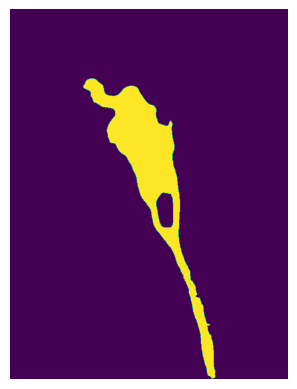

In [22]:
#display the best segment
plt.imshow(best_depth_mask)
plt.axis('off')
plt.show()

[154 289 424 559 694]


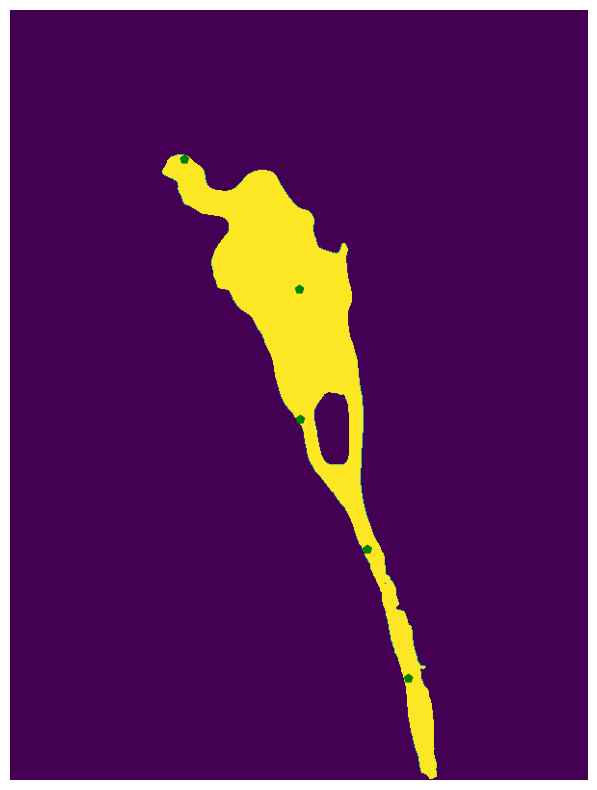

In [23]:
def thin_mask(mask, factor=1):
    """
    Thins the binary mask by the specified factor using morphological operations.
    
    Parameters:
    mask (np.array): Input binary mask.
    factor (int): The factor by which to thin the mask.
    
    Returns:
    np.array: Thinned binary mask.
    """
    # Validate the input
    if not isinstance(mask, np.ndarray):
        raise ValueError("The mask should be a numpy array.")
    if mask.dtype != np.uint8:
        # Convert the mask to a binary mask
        mask = (mask > 0).astype(np.uint8)
    if factor < 1:
        raise ValueError("The factor should be a positive integer.")
    
    # Create the structuring element for erosion
    kernel_size = (2 * factor + 1, 2 * factor + 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, kernel_size)
    
    # Apply the erosion
    thinned_mask = cv2.erode(mask, kernel, iterations=1)
    
    return thinned_mask

def place_vertical_points(binary_mask_coords, points_n=5, padding=100):
    """
    Coloca cuatro puntos verticales equidistantes centrados en la imagen global,
    pero las coordenadas y comienzan en la parte inferior de la máscara y terminan en la parte superior.
    
    :param binary_mask_coords: Array de coordenadas de los valores verdaderos en la máscara.
    :param image_shape: Tuple que representa la forma de la imagen (alto, ancho).
    :return: Lista de coordenadas de los puntos.
    """
    # Obtener los límites de la máscara
    y_coords = np.argwhere(binary_mask_coords == 1)[:, 0]
    coords = np.argwhere(binary_mask_coords == 1)
    height, length = binary_mask_coords.shape
    mid_length = length // 2
    
    min_y, max_y = np.min(y_coords), np.max(y_coords)
    
    # Calcular las posiciones verticales equidistantes dentro de la máscara
    vertical_positions = np.linspace(min_y, max_y - padding, points_n, dtype=int)
    print(vertical_positions)
    
    # Buscar el punto más cercano al mid_length en x para cada posición vertical
    points = []
    for y in vertical_positions:
        x_coords = coords[coords[:, 0] == y][:, 1]
        if len(x_coords) > 0:
            x = x_coords[np.argmin(np.abs(x_coords - mid_length))]
            points.append((y, x))
    
    return np.array(points)

def get_mask_bbox(mask):
    """
    Obtiene las coordenadas de la caja delimitadora de una máscara.

    :param mask: Máscara binaria.
    :return: Coordenadas de la caja delimitadora.
    """
    
    y_coords, x_coords = np.argwhere(mask==1).T
    return np.array([np.min(x_coords), np.min(y_coords), np.max(x_coords), np.max(y_coords)])


#display the vertical points
inside_points = place_vertical_points(thin_mask(best_depth_mask, factor=4), points_n=5)
depth_mask_bbox = get_mask_bbox(best_depth_mask)

plt.figure(figsize=(10,10))
plt.imshow(best_depth_mask)
plt.scatter(inside_points[:, 1], inside_points[:, 0], color='green', marker='p')
plt.axis('off')

#defining the points for segmentation with their labels
segmentation_points = inside_points
segmentation_points = np.array([[point[1], point[0]] for point in segmentation_points])
segmentation_labels = np.ones(inside_points.shape[0])

In [24]:
depth_mask_bbox

array([158, 150, 442, 798], dtype=int64)

In [25]:
# # add a margin to the xyxy bbox
h_margin = 80
w_margin = 20

depth_mask_bbox[0] = max(0, depth_mask_bbox[0] - w_margin)
depth_mask_bbox[1] = max(0, depth_mask_bbox[1] - h_margin)
depth_mask_bbox[2] = min(test_image.shape[1], depth_mask_bbox[2] + w_margin)
depth_mask_bbox[3] = min(test_image.shape[0], depth_mask_bbox[3] + h_margin)

In [26]:
segmentation_points, segmentation_labels, depth_mask_bbox

(array([[180, 154],
        [300, 289],
        [301, 424],
        [370, 559],
        [413, 694]], dtype=int64),
 array([1., 1., 1., 1., 1.]),
 array([138,  70, 462, 800], dtype=int64))

In [27]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(test_image)


masks, scores, logits = predictor.predict(
    point_coords=segmentation_points,
    point_labels=segmentation_labels,
    multimask_output=False,
    box=depth_mask_bbox,
)

(800, 600, 3)
(800, 600) (800, 600)


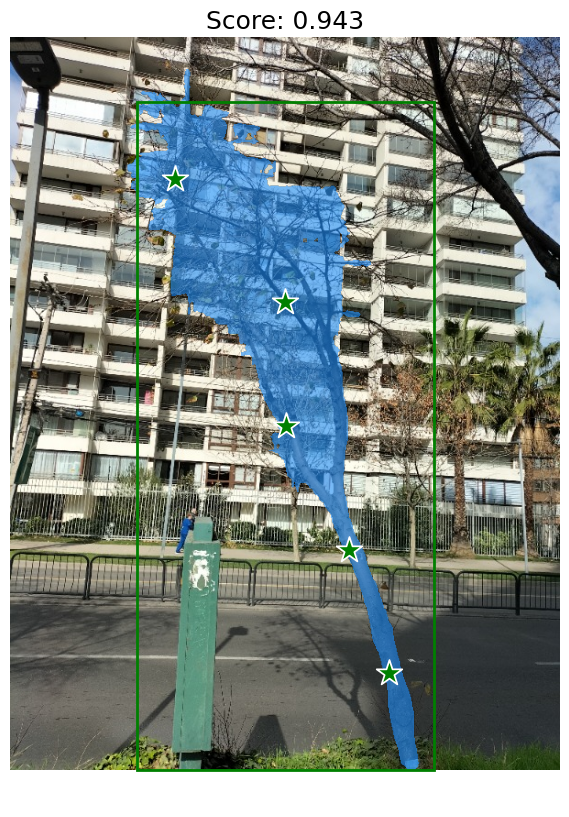

In [28]:
objective_mask = masks[0]
score = scores[0]
print(test_image.shape)

isolated_mask = isolate_largest_segment(objective_mask)
isolated_bbox = find_objects(isolated_mask)[0]
y_slice, x_slice = isolated_bbox

print(isolated_mask.shape, objective_mask.shape)
# Convert slices to bbox coordinates
isolated_bbox = np.array([x_slice.start, y_slice.start, x_slice.stop, y_slice.stop])

plt.figure(figsize=(10,10))
plt.imshow(test_image)
show_mask(isolated_mask, plt.gca())
show_points(segmentation_points, segmentation_labels, plt.gca())
show_box(depth_mask_bbox, plt.gca())
plt.title(f"Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show()

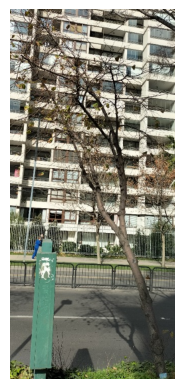

[{'scores': tensor([0.4333], device='cuda:0'),
  'labels': ['a tree'],
  'boxes': tensor([[  2.6643,   4.7581, 320.0164, 723.7227]], device='cuda:0')}]

In [29]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

tree_image = test_image[depth_mask_bbox[1]:depth_mask_bbox[3], depth_mask_bbox[0]:depth_mask_bbox[2]]

plt.imshow(tree_image)
plt.axis('off')
plt.show()

model_id = "IDEA-Research/grounding-dino-base"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
# Check for cats and remote controls
text = "a tree. a branch . a leaf"

inputs = processor(images=tree_image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.2,
    text_threshold=0.3,
    target_sizes=[tree_image.shape[:-1]]
)

results

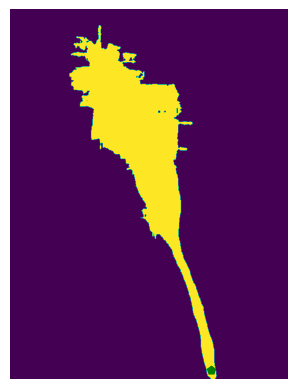

(-0.5, 599.5, 799.5, -0.5)

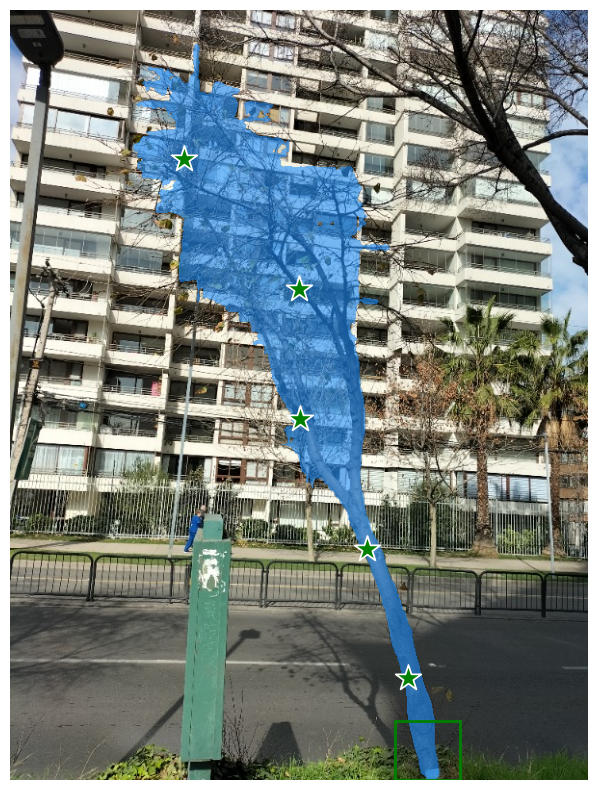

In [30]:
# a centered bbox on the bottom of the isolated mask

def find_middle_bottom(mask, padding=20):
    """
    Encuentra el punto medio en la parte inferior de una máscara.

    :param mask: Máscara binaria.
    :return: Coordenadas del punto medio en la parte inferior.
    """
    coords = np.argwhere(mask==1)
    y_min_bottom = np.max(coords[:, 0]) - padding
    x_coords = coords[coords[:, 0] == y_min_bottom][:, 1]
    x_bottom_point = np.mean(x_coords)
    x_diameter = np.max(x_coords) - np.min(x_coords)

    return np.array([x_bottom_point, y_min_bottom]), x_diameter

def define_search_card_bbox(isolated_mask, width_padding=50, height_padding=20):
    """
    Define la caja delimitadora de búsqueda para una máscara aislada.

    :param isolated_mask: Máscara binaria aislada.
    :return: Coordenadas de la caja delimitadora de búsqueda.
    """
    middle_bottom, x_diameter = find_middle_bottom(isolated_mask)
    search_card_bbox_height = (isolated_mask.shape[0] - middle_bottom[1])*2

    search_card_bbox_length = x_diameter + width_padding

    if search_card_bbox_height > 200:
        height_padding = -height_padding

    # Definir la caja delimitadora de búsqueda con middle_bottom en el centro en h y w
    search_card_bbox = np.array([int(middle_bottom[0] - search_card_bbox_length//2), 
                                int(middle_bottom[1] - search_card_bbox_height//2 - height_padding), 
                                int(middle_bottom[0] + search_card_bbox_length//2), 
                                int(middle_bottom[1] + search_card_bbox_height//2 -1)])
    
    plt.imshow(isolated_mask)
    plt.scatter(middle_bottom[0], middle_bottom[1], color='green', marker='p')
    plt.axis('off')
    plt.show()

    return search_card_bbox

#defining the search card bbox with middle_bottom at the center on h and w
search_card_bbox = define_search_card_bbox(isolated_mask)



plt.figure(figsize=(10,10))
plt.imshow(test_image)
show_mask(isolated_mask, plt.gca())
show_points(segmentation_points, segmentation_labels, plt.gca())
show_box(search_card_bbox, plt.gca())
plt.axis('off')

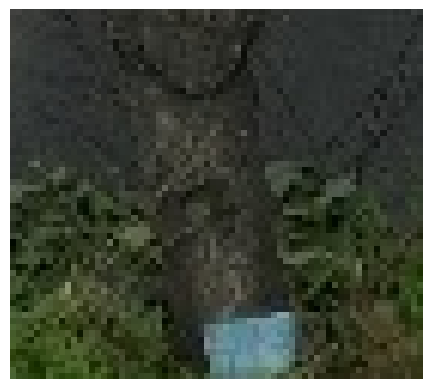

In [31]:
#crop the search card bbox from the image
search_card = test_image[search_card_bbox[1]:search_card_bbox[3], search_card_bbox[0]:search_card_bbox[2]]

plt.imshow(search_card)
plt.axis('off')
plt.show()

In [32]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model_id = "IDEA-Research/grounding-dino-base"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
# Check for cats and remote controls
text = "credit card . business card ."

inputs = processor(images=search_card, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.2,
    text_threshold=0.3,
    target_sizes=[search_card.shape[:-1]]
)

results

[{'scores': tensor([0.5060], device='cuda:0'),
  'labels': ['business card'],
  'boxes': tensor([[31.2532, 49.1549, 47.8185, 61.0014]], device='cuda:0')}]

[[31 49 47 61]]


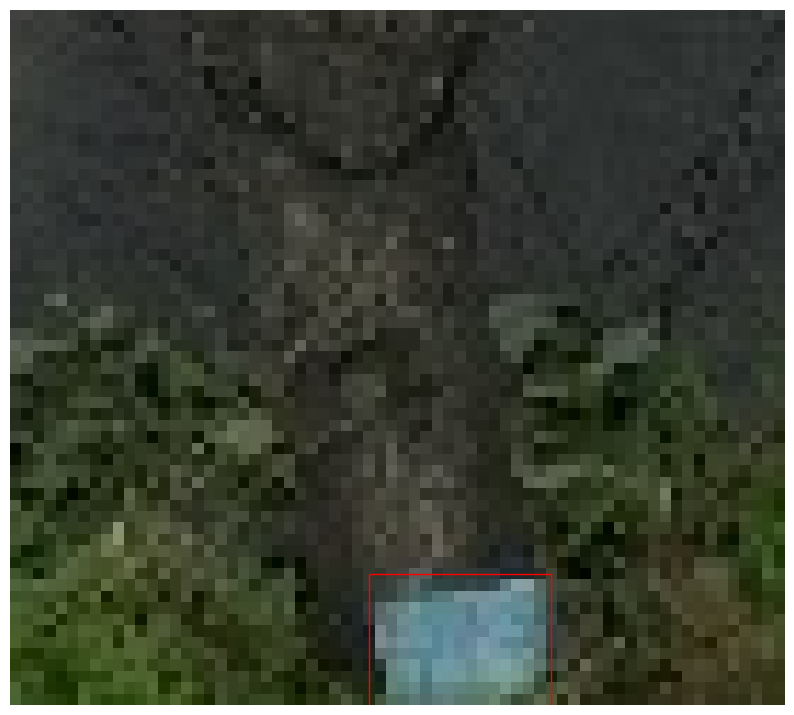

In [33]:
import matplotlib.patches as patches

search_card #np array of the search card image
card_bboxes = results[0]["boxes"]
card_bboxes = card_bboxes.cpu().numpy().astype(int)
card_scores = results[0]["scores"]
card_scores = card_scores.cpu().numpy()
labels = results[0]["labels"]

def card_is_in_labels(labels):
    labels = ''.join(labels)
    return 'card' in labels

if len(card_bboxes) == 0 or not card_is_in_labels(labels):
    print("No objects detected")
    scores = [0]
    card_center = np.array([])

else: 
    best_score_index = np.argmax(scores)
    best_card_bbox = card_bboxes[best_score_index]
    #convert the boxes tensor to a numpy array of ints
    card_center = np.array([[(best_card_bbox[0] + best_card_bbox[2])//2, (best_card_bbox[1] + best_card_bbox[3])//2]])
print(card_bboxes)

#display the search card image with the boxes
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(search_card)
if len(card_bboxes) > 0:
    rect = patches.Rectangle((best_card_bbox[0], best_card_bbox[1]), best_card_bbox[2] - best_card_bbox[0], best_card_bbox[3] - best_card_bbox[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.axis('off')
plt.show()

In [34]:
if len(card_center) == 1:
    predictor.set_image(search_card)


    masks, scores, logits = predictor.predict(
        point_coords=card_center,
        point_labels=np.ones(1),
        multimask_output=False,
        box=best_card_bbox,
    )

    card_mask = masks[0]

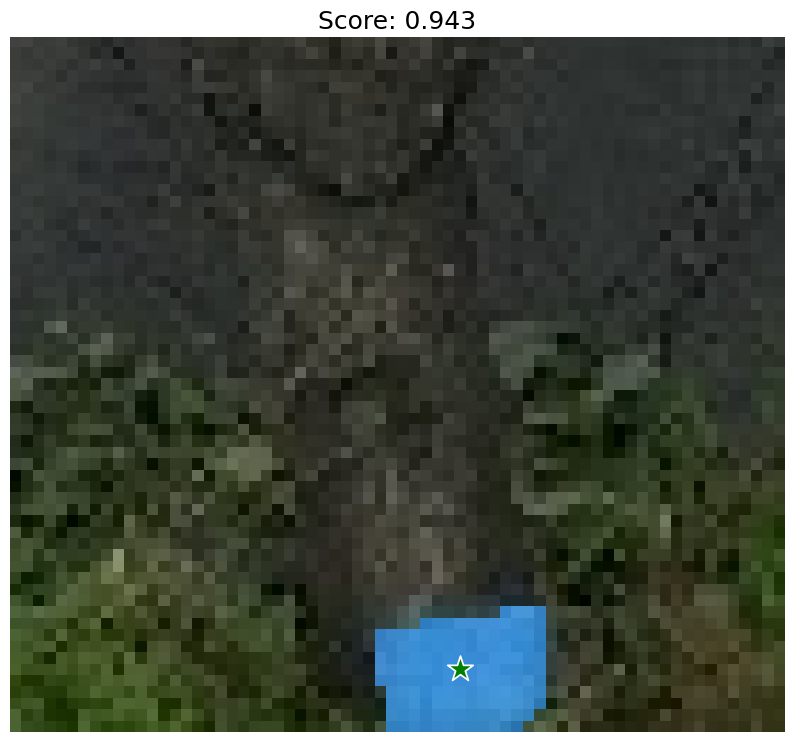

In [35]:
if len(card_center) == 1:
  plt.figure(figsize=(10,10))
  plt.imshow(search_card)
  show_mask(card_mask, plt.gca())
  show_points(card_center, np.ones(1), plt.gca())
  plt.title(f"Score: {score:.3f}", fontsize=18)
  plt.axis('off')
  plt.show()

In [36]:
# grap the mask in to an romboid shape of four points and parallel sides
def find_best_bounding_box(mask):
    # Ensure the input is a binary mask
    if len(mask.shape) != 2 or not np.issubdtype(mask.dtype, np.bool_):
        raise ValueError("Input mask must be a 2D binary array")

    # Convert the binary mask to an integer mask for OpenCV functions
    mask = mask.astype(np.uint8)

    # Find contours of the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found in the mask")

    # Find the minimum area bounding rectangle
    rect = cv2.minAreaRect(contours[0])
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Compute IoU of the bounding box with the mask
    mask_box = np.zeros_like(mask)
    cv2.drawContours(mask_box, [box], 0, 1, -1)
    intersection = np.sum((mask_box & mask))
    union = np.sum((mask_box | mask))
    iou = intersection / union

    return box, iou

def angle_between_points(p1, p2):
    return np.degrees(np.arctan2(p2[1] - p1[1], p2[0] - p1[0]))

def is_parallel_sides(box):

    # Calculate angles of all four sides
    angles = [
        angle_between_points(box[0], box[1]),
        angle_between_points(box[1], box[2]),
        angle_between_points(box[2], box[3]),
        angle_between_points(box[3], box[0])
    ]

    # Adjust angles to be within the range [0, 180]
    angles = [angle % 180 for angle in angles]

    # Check if opposite sides are parallel (difference in angles should be 0 or 180)
    parallel_sides = (np.isclose(angles[0], angles[2]) or np.isclose(abs(angles[0] - angles[2]), 180)) and \
                     (np.isclose(angles[1], angles[3]) or np.isclose(abs(angles[1] - angles[3]), 180))

    return parallel_sides

if len(card_center) == 1:
    romboid_points, iou = find_best_bounding_box(card_mask)

    plt.figure(figsize=(10,10))
    plt.imshow(search_card)
    show_mask(card_mask, plt.gca())
    show_points(romboid_points, np.ones(4), plt.gca())
    plt.axis('off')
    plt.show()

    print(iou, is_parallel_sides(romboid_points))

C:\Users\jflir\AppData\Local\Temp\ipykernel_11772\1804250411.py:18: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


0.8666666666666667 True


In [37]:
# given the standard size of a credit card, we calculate the mm per pixel ratio using an afine transformation

standard_card_width = 85.6
standard_card_height = 53.98

def calculate_mm_per_pixel(romboid_points, standard_card_width, standard_card_height):
    # Define the standard card points
    standard_card_points = np.array([[0, 0], [standard_card_width, 0], [standard_card_width, standard_card_height], [0, standard_card_height]])

    # check the long and short side of the romboid
    romboid_sides = np.linalg.norm(np.diff(romboid_points, axis=0), axis=1)
    romboid_long_side_index = np.argmax(romboid_sides)
    romboid_short_side_index = np.argmin(romboid_sides)

    #if needed rotate the romboid points to match the standard card points
    if romboid_long_side_index == 1:
        romboid_points = np.roll(romboid_points, 1, axis=0)
    elif romboid_long_side_index == 2:
        romboid_points = np.roll(romboid_points, 2, axis=0)
    elif romboid_long_side_index == 3:
        romboid_points = np.roll(romboid_points, 3, axis=0)

    # Calculate the affine transformation matrix
    affine_matrix = cv2.getPerspectiveTransform(romboid_points.astype(np.float32), standard_card_points.astype(np.float32))

    # Calculate the mm per pixel ratio
    mm_per_pixel = np.linalg.norm(affine_matrix[:, 0])

    return mm_per_pixel

if len(card_center) == 1:
    mm_per_pixel = calculate_mm_per_pixel(romboid_points, standard_card_width, standard_card_height)
    print(mm_per_pixel)


6.114285605294358


In [38]:
# get the tree height in mm

def calculate_tree_height(mask, mm_per_pixel):
    # Calculate the height of the tree in pixels
    x_cords = np.argwhere(mask)
    tree_height_pixels = np.max(x_cords) - np.min(x_cords)

    # Convert the height to mm
    tree_height_mm = tree_height_pixels * mm_per_pixel

    return tree_height_mm

if len(card_center) == 1:
    tree_height_mm = calculate_tree_height(isolated_mask, mm_per_pixel)
    print(tree_height_mm/1000)

4.67131420244489


# Trunk and Crown segmentation

In [39]:
# graph the tree height and width in pixels using the mask
def plot_tree_dimensions(mask):
    # Calculate the height of the tree in pixels
    y_coords = np.unique(np.argwhere(mask)[:, 0])

    diameters = []

    for y in y_coords:
        x_cords = np.argwhere(mask[y])
        diameter = np.max(x_cords) - np.min(x_cords)
        diameters.append(diameter)
    

    # y_cords at the x axis and diameters at the y axis
    plt.figure(figsize=(10, 6))
    plt.plot(y_coords, diameters)
    plt.title("Tree Diameter in Pixels")
    plt.xlabel("Height (Pixels)")
    plt.ylabel("Diameter (Pixels)")
    plt.show()

    return diameters, y_coords

pixel_diameters, tree_y_coords = plot_tree_dimensions(isolated_mask)


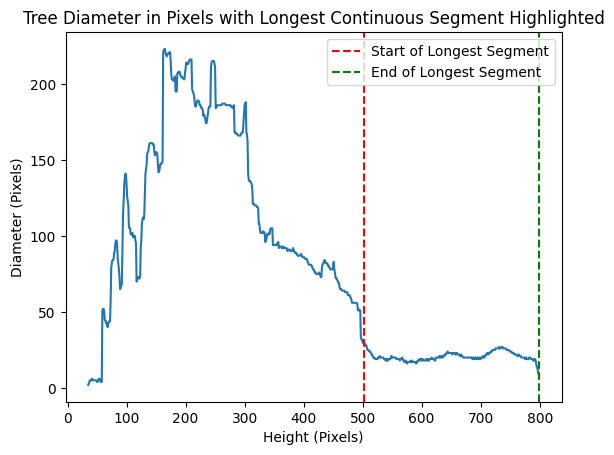

In [40]:
def find_longest_continuous_segment(width_profile, tolerance=10):
    """
    Find the longest continuous segment where the diameter is relatively constant.

    :param width_profile: List or array of width values.
    :param tolerance: Tolerance for changes in diameter (default is 5 pixels).
    :return: Start and end indices of the longest continuous segment.
    """
    max_length = 0
    current_length = 0
    start_idx = 0
    longest_segment = (0, 0)
    n_args = len(width_profile)
    
    for i in range(int(n_args*0.2), n_args):
        if abs(width_profile[i] - width_profile[i - 5]) <= tolerance:
            current_length += 1
            if current_length > max_length:
                max_length = current_length
                longest_segment = (start_idx, i)
        else:
            current_length = 0
            start_idx = i
    
    return longest_segment


trunk_segment = find_longest_continuous_segment(moving_average(pixel_diameters, window_size=10))
trunk_start = tree_y_coords[trunk_segment[0]]
trunk_end = tree_y_coords[-1]

# Plot the width profile and highlight the longest segment
plt.plot(tree_y_coords, pixel_diameters)
plt.axvline(tree_y_coords[trunk_segment[0]], color='r', linestyle='--', label='Start of Longest Segment')
plt.axvline(tree_y_coords[trunk_segment[1]], color='g', linestyle='--', label='End of Longest Segment')
plt.xlabel('Height (Pixels)')
plt.ylabel('Diameter (Pixels)')
plt.title('Tree Diameter in Pixels with Longest Continuous Segment Highlighted')
plt.legend()
plt.show()

[506 553 600 647 694]


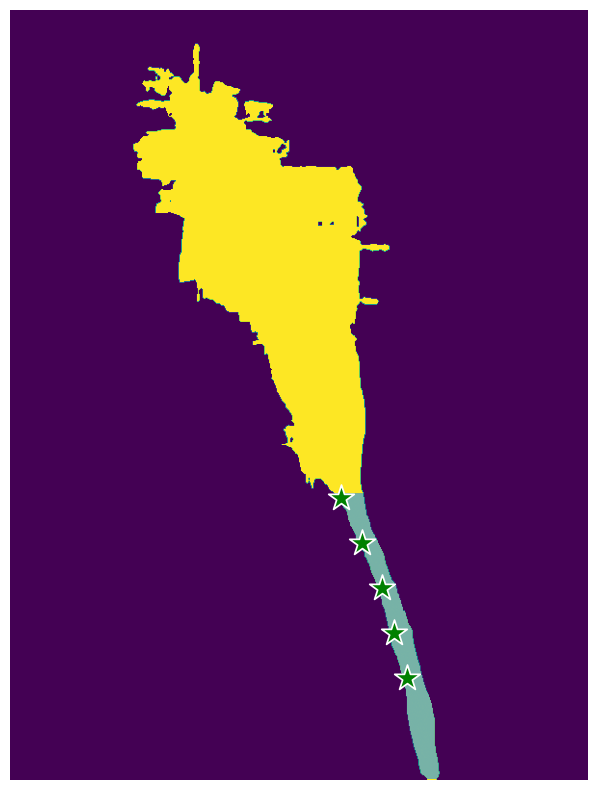

In [41]:
# isolate the trunk from the mask
def isolate_trunk_crown_masks(mask, start, end):
    """
    Isolate the trunk from a mask based on the start and end indices.

    :param mask: Binary mask of the tree.
    :param start: Start index of the trunk.
    :param end: End index of the trunk.
    :return: Binary mask of the trunk.
    """
    trunk_mask = np.zeros_like(mask)
    trunk_mask[start:end, :] = mask[start:end, :]
    crown_mask = mask.copy()
    crown_mask[start:end, :] = 0

    return trunk_mask, crown_mask

trunk_mask, crown_mask = isolate_trunk_crown_masks(isolated_mask, trunk_start, trunk_end)

trunk_inside_points = place_vertical_points(thin_mask(trunk_mask, factor=4), points_n=5)
trunk_inside_points = np.array([[point[1], point[0]] for point in trunk_inside_points])
trunk_inside_labels = np.ones(trunk_inside_points.shape[0])
trunk_mask_bbox = get_mask_bbox(trunk_mask)

#display the trunk and crown masks with the points
plt.figure(figsize=(10,10))
plt.imshow(isolated_mask)
show_mask(trunk_mask, plt.gca())
if len(trunk_inside_points) > 0:
    show_points(trunk_inside_points, trunk_inside_labels, plt.gca())
plt.axis('off')
plt.show()



In [42]:
predictor = SamPredictor(sam)

predictor.set_image(test_image)


masks, scores, logits = predictor.predict(
    point_coords=trunk_inside_points,
    point_labels=trunk_inside_labels,
    multimask_output=False,
    box=trunk_mask_bbox,
)

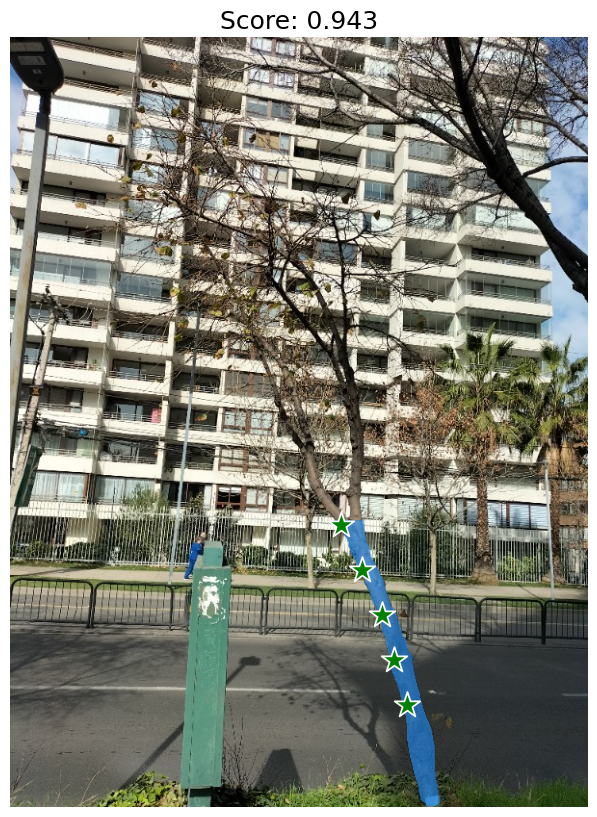

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(test_image)
show_mask(trunk_mask, plt.gca())
show_points(trunk_inside_points, trunk_inside_labels, plt.gca())
plt.title(f"Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show()

### Out of use

c:\Users\jflir\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


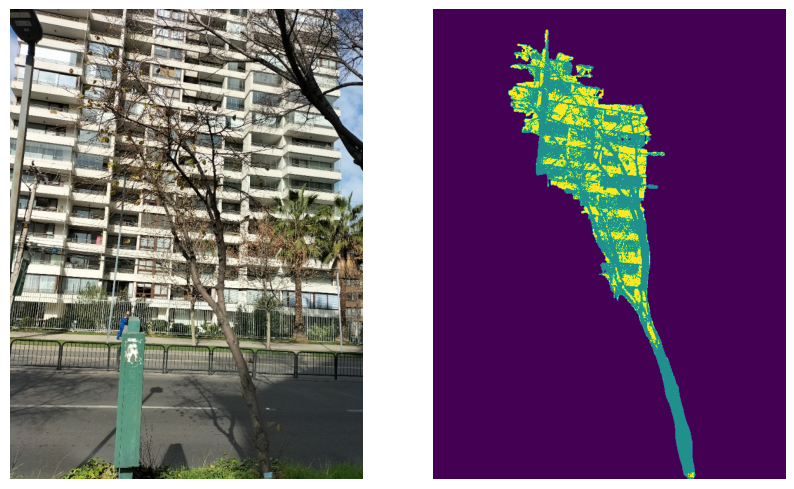

In [44]:
from sklearn.cluster import KMeans

# using k means segment the colors of the insolated mask of the tree

def segment_colors(image, mask, n_colors=4):
    # Get the RGB values of the pixels in the mask
    masked_pixels = image[mask]
    # Reshape the pixels to a 2D array
    masked_pixels = masked_pixels.reshape(-1, 3)
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(masked_pixels)
    # Get the cluster centers
    colors = kmeans.cluster_centers_
    # Get the labels of the pixels
    labels = kmeans.labels_
    # Create a mask with the cluster labels
    color_mask = np.zeros(mask.shape)
    color_mask[mask] = labels + 1
    return color_mask, colors

color_mask, colors = segment_colors(test_image, isolated_mask, n_colors=2)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(test_image)
plt.axis('off')
plt.subplot(122)
plt.imshow(color_mask)
plt.axis('off')
plt.show()

In [ ]:
def generate_grid(image_shape, density, percent_columns_to_remove):
    """
    Genera una cuadrícula de coordenadas que cubre toda la imagen con una densidad especificada
    y elimina un porcentaje de columnas en el centro.

    :param image_shape: Tuple que representa la forma de la imagen (alto, ancho).
    :param density: Float que define la densidad de la cuadrícula (0 a 1).
    :param percent_columns_to_remove: Float que define el porcentaje de columnas a eliminar en el centro (0 a 1).
    :return: Array de coordenadas que cubren la imagen.
    """
    height, width = image_shape

    # Calcular el número de pasos basados en la densidad
    num_steps_x = int(width * density)
    num_steps_y = int(height * density)
    
    # Asegurarse de que siempre haya al menos una columna y una fila en los bordes
    num_steps_x = np.max([num_steps_x, 2])
    num_steps_y = np.max([num_steps_y, 2])
    
    # Calcular la distancia entre pasos
    step_size_x = width / (num_steps_x - 1)
    step_size_y = height / (num_steps_y - 1)
    
    # Generar la cuadrícula de coordenadas
    x_coords = np.linspace(0, width - 1, num_steps_x, dtype=int)
    y_coords = np.linspace(0, height - 1, num_steps_y, dtype=int)
    grid = np.array(np.meshgrid(y_coords, x_coords)).T.reshape(-1, 2)
    
    # Calcular el rango de columnas a eliminar en el centro
    num_columns_to_remove = int(num_steps_x * percent_columns_to_remove)
    center_x_index = num_steps_x // 2
    half_remove = num_columns_to_remove // 2
    start_remove_index = center_x_index - half_remove
    end_remove_index = center_x_index + half_remove
    
    # Filtrar las coordenadas para eliminar las columnas centrales
    filtered_grid = [coord for coord in grid if not (start_remove_index <= np.where(x_coords == coord[1])[0][0] < end_remove_index)]

    return np.array(filtered_grid)

#display the grid points
# grid_points = generate_grid(best_depth_mask.shape, 0.021,0)
# plt.scatter(grid_points[:, 1], grid_points[:, 0], color='gray', marker='o')
# plt.imshow(best_depth_mask)
# plt.axis('off')